In [1]:
import copy
import os
import sys
from pathlib import Path

import numpy as np
from qutip.solver.floquet import progress_bars
import torch
from pulser import Pulse, Register, Sequence
from pulser.devices import MockDevice
from pulser_diff.backend import TorchEmulator
from pyqtorch.utils import SolverType
from torch import Tensor
import json
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import h5py as h5
import scienceplots

In [2]:
sys.path.append("../../..")

In [3]:
from source.NAHEA_CNN import NAHEA_CNN_1_QNoTrain

In [4]:
plt.style.use(["science", "grid"])

In [5]:
# load data from sin dataset
data_save_dir = Path("../../../data") / "sin"
data_save_path_train = data_save_dir / "train.h5"
data_save_path_test = data_save_dir / "test.h5"

with h5.File(data_save_path_train, "r") as f:
    X_train_full = f["X"][:].squeeze(2)
    y_train_full = f["y"][:]

with h5.File(data_save_path_test, "r") as f:
    X_test = f["X"][:].squeeze(2)
    y_test = f["y"][:]

print(f"X_train shape: {X_train_full.shape}")
print(f"y_train shape: {y_train_full.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (4000, 18)
y_train shape: (4000, 1)
X_test shape: (1000, 18)
y_test shape: (1000, 1)


In [6]:
n_train = 150
n_val = 250 # validation is much faster than training
n_test = 500 # testing is much faster than training
X_train = X_train_full[:n_train]
y_train = y_train_full[:n_train]
X_val = X_train_full[n_train:n_train+n_val]
y_val = y_train_full[n_train:n_train+n_val]
X_test = X_test[:n_test]
y_test = y_test[:n_test]

seq_len = X_train.shape[1]

Saved figure to figures/generated_sin_wave_data_samples.pdf


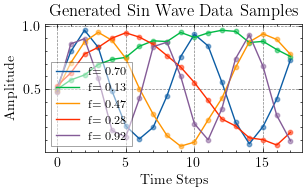

In [7]:
# plot some data
textwidth = 3.31314
aspect_ratio = 4/8
scale = 1.0
width = textwidth * scale
height = width * aspect_ratio
fig = plt.figure(figsize=(width, height))
# plt.figure(figsize=(10, 5))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(5):
    plt.plot(X_train[i].flatten(), label=f"f= {y_train[i][0]:.2f}", color=colors[i % len(colors)])
    plt.scatter(np.arange(seq_len), X_train[i].flatten(), color=colors[i % len(colors)], s=10, alpha=0.5)
plt.title("Generated Sin Wave Data Samples")
plt.xlabel("Time Steps")
plt.ylabel("Amplitude")
legend = plt.legend(fancybox=False, edgecolor="black", fontsize='small', framealpha=0.5)
legend.get_frame().set_linewidth(0.5)
path = Path("figures")
path.mkdir(parents=True, exist_ok=True)
plt.savefig(path / "generated_sin_wave_data_samples.pdf", bbox_inches='tight', dpi=300)
print(f"Saved figure to {path / 'generated_sin_wave_data_samples.pdf'}")
plt.show()

In [8]:
seq_len = X_train.shape[1]
hparams = {
    "n_features": (n_features := 4),  # =1D kernel size = number of qubits
    "sampling_rate": 0.2,
    "protocol": "min-delay",
    "n_ancilliary_qubits": (n_ancilliary_qubits := 0), # not implemented
    "input_length": seq_len,
    "stride": 3,  # stride for the convolution
    "output_dim": 1,  # output dimension of the final FC NN
    "hidden_layers_dims": [10, 5],
}

sep = 7.0
parameters = {
    # separation of 7 between the qubits
    "positions": [[sep * i - (sep * 2), 0] for i in range(n_features)],
    "local_pulses_omega_1": [0.5, 1.0, 1.5, 1.0], #, 0.5],
    "local_pulses_delta_1": [0.0] * n_features,
    "global_pulse_omega_1": 1.0,
    "global_pulse_delta_1": 0.0,
    "global_pulse_omega_2": 0.5,
    "global_pulse_delta_2": 0.0,
    "global_pulse_duration": 100,
    "local_pulse_duration": 80,
    "embed_pulse_duration": 80,
}


NAHEA_CNN = NAHEA_CNN_1_QNoTrain(
    hparams=hparams, parameters=parameters, name="NAHEA_CNN_1_QNoTrain",
)

# set some parameters to not require gradients. They didn't change much last time
NAHEA_CNN._parameters["positions"].requires_grad = False
NAHEA_CNN._parameters["local_pulses_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_1"].requires_grad = False
NAHEA_CNN._parameters["global_pulse_delta_2"].requires_grad = False

Adding parameter 0.weight to model
Adding parameter 0.bias to model
Adding parameter 2.weight to model
Adding parameter 2.bias to model
Adding parameter 4.weight to model
Adding parameter 4.bias to model


In [9]:
from multiprocessing import Pool

def forward_no_grad(xx: Tensor):
    with torch.no_grad():
        return NAHEA_CNN.forward(xx, dist_grad=False)
n_cpus = 10

In [10]:
# train the model
x_val = torch.tensor(X_val, dtype=torch.float64)
y_val = torch.tensor(y_val, dtype=torch.float64)
if len(y_val.shape) == 2:
    y_val = y_val.squeeze(1)  # make sure y_val is 2D
batch_size = 16
epochs = 50
loss_hist = []
loss_hist_val = []
# MSE loss function
loss_fn = torch.nn.MSELoss()
NAHEA_CNN.train()
optimizer = torch.optim.Adam(
    [param for _, param in NAHEA_CNN.parameters().items() if param.requires_grad],
    lr=0.01,
    weight_decay=1e-5,
)
params_hist = [copy.deepcopy(NAHEA_CNN.parameters())]
for epoch in range(epochs):
    NAHEA_CNN.train()
    # shuffle X_train and y_train
    idxs = np.arange(len(X_train))
    idxs = np.random.permutation(idxs)
    X_train = X_train[idxs]
    y_train = y_train[idxs]

    epoch_losses = []
    for i in tqdm(range(0, len(X_train), batch_size), desc=f"Epoch {epoch+1}", leave=False):
        optimizer.zero_grad()
        x_batch = torch.tensor(X_train[i : i + batch_size], dtype=torch.float64)
        y_batch = torch.tensor(
            y_train[i : i + batch_size], dtype=torch.float64
        ).squeeze(1)
        batch_out = [NAHEA_CNN.forward(xx, dist_grad=False) for xx in x_batch]
        predicted = torch.stack([bo["output"] for bo in batch_out])
        loss = loss_fn(predicted.squeeze(1), y_batch)
        tqdm.write(
            f"Batch {i // batch_size + 1} loss: {loss.item():.4f}, "
            f"RMSE: {np.sqrt(loss.item()):.4f}"
        )
        epoch_losses.append(loss.item())
        loss_hist.append(loss.item())
        loss.backward()
        optimizer.step()
        params_hist.append(copy.deepcopy(NAHEA_CNN.parameters()))
    epoch_loss = np.mean(epoch_losses)

    # validation
    with torch.no_grad():
        NAHEA_CNN.eval()
        with Pool(n_cpus) as pool:
            batch_out = list(tqdm(pool.imap(forward_no_grad, torch.tensor(X_val, dtype=torch.float64)), desc="Validation", total=len(X_val), leave=False))
        predicted = torch.stack([bo["output"] for bo in batch_out])
        val_loss = loss_fn(predicted.squeeze(1), y_val)
        loss_hist_val.append(val_loss.item())
    tqdm.write(f"Epoch {epoch+1}: train RMSE: {np.sqrt(epoch_loss):.4f}, "
               f"validation RMSE: {np.sqrt(val_loss.item()):.4f}")
loss_hist = np.array(loss_hist)
print(f"Final loss (RMSE): {np.sqrt(loss_hist[-1])}")
print(f"Final validation loss (RMSE): {np.sqrt(loss_hist_val[-1])}")

Epoch 1:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.3255, RMSE: 0.5706
Batch 2 loss: 0.1486, RMSE: 0.3855
Batch 3 loss: 0.2260, RMSE: 0.4754
Batch 4 loss: 0.1600, RMSE: 0.4001
Batch 5 loss: 0.1525, RMSE: 0.3906
Batch 6 loss: 0.1086, RMSE: 0.3296
Batch 7 loss: 0.0941, RMSE: 0.3068
Batch 8 loss: 0.0423, RMSE: 0.2057
Batch 9 loss: 0.0672, RMSE: 0.2592
Batch 10 loss: 0.0446, RMSE: 0.2113


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1: train RMSE: 0.3701, validation RMSE: 0.2850


Epoch 2:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0863, RMSE: 0.2937
Batch 2 loss: 0.1077, RMSE: 0.3282
Batch 3 loss: 0.0819, RMSE: 0.2862
Batch 4 loss: 0.0724, RMSE: 0.2691
Batch 5 loss: 0.0948, RMSE: 0.3079
Batch 6 loss: 0.1086, RMSE: 0.3296
Batch 7 loss: 0.0670, RMSE: 0.2589
Batch 8 loss: 0.0707, RMSE: 0.2659
Batch 9 loss: 0.0638, RMSE: 0.2525
Batch 10 loss: 0.0712, RMSE: 0.2668


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 2: train RMSE: 0.2871, validation RMSE: 0.2627


Epoch 3:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0514, RMSE: 0.2266
Batch 2 loss: 0.0597, RMSE: 0.2443
Batch 3 loss: 0.0786, RMSE: 0.2803
Batch 4 loss: 0.0759, RMSE: 0.2755
Batch 5 loss: 0.0495, RMSE: 0.2226
Batch 6 loss: 0.0626, RMSE: 0.2501
Batch 7 loss: 0.0489, RMSE: 0.2210
Batch 8 loss: 0.0774, RMSE: 0.2782
Batch 9 loss: 0.0683, RMSE: 0.2614
Batch 10 loss: 0.0325, RMSE: 0.1803


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 3: train RMSE: 0.2459, validation RMSE: 0.2630


Epoch 4:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0879, RMSE: 0.2965
Batch 2 loss: 0.0591, RMSE: 0.2432
Batch 3 loss: 0.0420, RMSE: 0.2048
Batch 4 loss: 0.0510, RMSE: 0.2258
Batch 5 loss: 0.0457, RMSE: 0.2138
Batch 6 loss: 0.0505, RMSE: 0.2246
Batch 7 loss: 0.0772, RMSE: 0.2778
Batch 8 loss: 0.0545, RMSE: 0.2334
Batch 9 loss: 0.0714, RMSE: 0.2673
Batch 10 loss: 0.0967, RMSE: 0.3109


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 4: train RMSE: 0.2522, validation RMSE: 0.2470


Epoch 5:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0587, RMSE: 0.2423
Batch 2 loss: 0.0516, RMSE: 0.2271
Batch 3 loss: 0.0562, RMSE: 0.2370
Batch 4 loss: 0.0430, RMSE: 0.2073
Batch 5 loss: 0.0623, RMSE: 0.2497
Batch 6 loss: 0.0465, RMSE: 0.2157
Batch 7 loss: 0.0585, RMSE: 0.2419
Batch 8 loss: 0.0635, RMSE: 0.2520
Batch 9 loss: 0.0663, RMSE: 0.2574
Batch 10 loss: 0.0348, RMSE: 0.1867


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 5: train RMSE: 0.2327, validation RMSE: 0.2461


Epoch 6:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0648, RMSE: 0.2545
Batch 2 loss: 0.0605, RMSE: 0.2460
Batch 3 loss: 0.0467, RMSE: 0.2162
Batch 4 loss: 0.0475, RMSE: 0.2178
Batch 5 loss: 0.0489, RMSE: 0.2212
Batch 6 loss: 0.0502, RMSE: 0.2241
Batch 7 loss: 0.0531, RMSE: 0.2304
Batch 8 loss: 0.0665, RMSE: 0.2578
Batch 9 loss: 0.0616, RMSE: 0.2482
Batch 10 loss: 0.0545, RMSE: 0.2334


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 6: train RMSE: 0.2354, validation RMSE: 0.2366


Epoch 7:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0502, RMSE: 0.2240
Batch 2 loss: 0.0394, RMSE: 0.1985
Batch 3 loss: 0.0603, RMSE: 0.2455
Batch 4 loss: 0.0390, RMSE: 0.1975
Batch 5 loss: 0.0813, RMSE: 0.2851
Batch 6 loss: 0.0601, RMSE: 0.2452
Batch 7 loss: 0.0534, RMSE: 0.2311
Batch 8 loss: 0.0583, RMSE: 0.2415
Batch 9 loss: 0.0490, RMSE: 0.2213
Batch 10 loss: 0.0184, RMSE: 0.1357


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 7: train RMSE: 0.2257, validation RMSE: 0.2260


Epoch 8:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0540, RMSE: 0.2323
Batch 2 loss: 0.0451, RMSE: 0.2124
Batch 3 loss: 0.0414, RMSE: 0.2035
Batch 4 loss: 0.0300, RMSE: 0.1732
Batch 5 loss: 0.0413, RMSE: 0.2033
Batch 6 loss: 0.0670, RMSE: 0.2588
Batch 7 loss: 0.0672, RMSE: 0.2592
Batch 8 loss: 0.0517, RMSE: 0.2274
Batch 9 loss: 0.0304, RMSE: 0.1744
Batch 10 loss: 0.0127, RMSE: 0.1126


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 8: train RMSE: 0.2099, validation RMSE: 0.2218


Epoch 9:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0459, RMSE: 0.2142
Batch 2 loss: 0.0628, RMSE: 0.2506
Batch 3 loss: 0.0518, RMSE: 0.2276
Batch 4 loss: 0.0456, RMSE: 0.2136
Batch 5 loss: 0.0374, RMSE: 0.1934
Batch 6 loss: 0.0427, RMSE: 0.2068
Batch 7 loss: 0.0276, RMSE: 0.1660
Batch 8 loss: 0.0352, RMSE: 0.1876
Batch 9 loss: 0.0484, RMSE: 0.2200
Batch 10 loss: 0.0449, RMSE: 0.2118


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 9: train RMSE: 0.2103, validation RMSE: 0.2049


Epoch 10:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0347, RMSE: 0.1864
Batch 2 loss: 0.0388, RMSE: 0.1970
Batch 3 loss: 0.0364, RMSE: 0.1907
Batch 4 loss: 0.0259, RMSE: 0.1608
Batch 5 loss: 0.0418, RMSE: 0.2044
Batch 6 loss: 0.0445, RMSE: 0.2110
Batch 7 loss: 0.0420, RMSE: 0.2049
Batch 8 loss: 0.0399, RMSE: 0.1998
Batch 9 loss: 0.0397, RMSE: 0.1991
Batch 10 loss: 0.0136, RMSE: 0.1168


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 10: train RMSE: 0.1890, validation RMSE: 0.1894


Epoch 11:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0225, RMSE: 0.1502
Batch 2 loss: 0.0371, RMSE: 0.1926
Batch 3 loss: 0.0393, RMSE: 0.1983
Batch 4 loss: 0.0279, RMSE: 0.1671
Batch 5 loss: 0.0285, RMSE: 0.1688
Batch 6 loss: 0.0336, RMSE: 0.1833
Batch 7 loss: 0.0302, RMSE: 0.1739
Batch 8 loss: 0.0330, RMSE: 0.1818
Batch 9 loss: 0.0239, RMSE: 0.1545
Batch 10 loss: 0.0304, RMSE: 0.1742


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 11: train RMSE: 0.1751, validation RMSE: 0.1646


Epoch 12:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0298, RMSE: 0.1727
Batch 2 loss: 0.0389, RMSE: 0.1972
Batch 3 loss: 0.0239, RMSE: 0.1545
Batch 4 loss: 0.0221, RMSE: 0.1487
Batch 5 loss: 0.0221, RMSE: 0.1485
Batch 6 loss: 0.0205, RMSE: 0.1431
Batch 7 loss: 0.0172, RMSE: 0.1313
Batch 8 loss: 0.0149, RMSE: 0.1221
Batch 9 loss: 0.0096, RMSE: 0.0981
Batch 10 loss: 0.0208, RMSE: 0.1441


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 12: train RMSE: 0.1482, validation RMSE: 0.1271


Epoch 13:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0117, RMSE: 0.1080
Batch 2 loss: 0.0154, RMSE: 0.1240
Batch 3 loss: 0.0185, RMSE: 0.1360
Batch 4 loss: 0.0116, RMSE: 0.1077
Batch 5 loss: 0.0074, RMSE: 0.0861
Batch 6 loss: 0.0107, RMSE: 0.1032
Batch 7 loss: 0.0080, RMSE: 0.0895
Batch 8 loss: 0.0117, RMSE: 0.1081
Batch 9 loss: 0.0073, RMSE: 0.0853
Batch 10 loss: 0.0081, RMSE: 0.0899


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 13: train RMSE: 0.1050, validation RMSE: 0.0753


Epoch 14:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0049, RMSE: 0.0697
Batch 2 loss: 0.0065, RMSE: 0.0805
Batch 3 loss: 0.0086, RMSE: 0.0929
Batch 4 loss: 0.0051, RMSE: 0.0716
Batch 5 loss: 0.0046, RMSE: 0.0680
Batch 6 loss: 0.0042, RMSE: 0.0644
Batch 7 loss: 0.0057, RMSE: 0.0754
Batch 8 loss: 0.0048, RMSE: 0.0693
Batch 9 loss: 0.0081, RMSE: 0.0898
Batch 10 loss: 0.0073, RMSE: 0.0853


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 14: train RMSE: 0.0772, validation RMSE: 0.0511


Epoch 15:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0032, RMSE: 0.0565
Batch 2 loss: 0.0067, RMSE: 0.0817
Batch 3 loss: 0.0059, RMSE: 0.0768
Batch 4 loss: 0.0043, RMSE: 0.0652
Batch 5 loss: 0.0039, RMSE: 0.0624
Batch 6 loss: 0.0039, RMSE: 0.0622
Batch 7 loss: 0.0049, RMSE: 0.0702
Batch 8 loss: 0.0041, RMSE: 0.0640
Batch 9 loss: 0.0031, RMSE: 0.0558
Batch 10 loss: 0.0019, RMSE: 0.0436


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 15: train RMSE: 0.0647, validation RMSE: 0.0476


Epoch 16:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0036, RMSE: 0.0596
Batch 2 loss: 0.0034, RMSE: 0.0581
Batch 3 loss: 0.0023, RMSE: 0.0481
Batch 4 loss: 0.0020, RMSE: 0.0450
Batch 5 loss: 0.0026, RMSE: 0.0508
Batch 6 loss: 0.0035, RMSE: 0.0591
Batch 7 loss: 0.0027, RMSE: 0.0516
Batch 8 loss: 0.0012, RMSE: 0.0345
Batch 9 loss: 0.0027, RMSE: 0.0522
Batch 10 loss: 0.0022, RMSE: 0.0471


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 16: train RMSE: 0.0511, validation RMSE: 0.0406


Epoch 17:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0019, RMSE: 0.0438
Batch 2 loss: 0.0013, RMSE: 0.0359
Batch 3 loss: 0.0009, RMSE: 0.0302
Batch 4 loss: 0.0015, RMSE: 0.0388
Batch 5 loss: 0.0031, RMSE: 0.0558
Batch 6 loss: 0.0024, RMSE: 0.0489
Batch 7 loss: 0.0012, RMSE: 0.0351
Batch 8 loss: 0.0013, RMSE: 0.0365
Batch 9 loss: 0.0008, RMSE: 0.0275
Batch 10 loss: 0.0013, RMSE: 0.0363


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 17: train RMSE: 0.0397, validation RMSE: 0.0347


Epoch 18:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0015, RMSE: 0.0388
Batch 2 loss: 0.0011, RMSE: 0.0326
Batch 3 loss: 0.0017, RMSE: 0.0407
Batch 4 loss: 0.0013, RMSE: 0.0363
Batch 5 loss: 0.0012, RMSE: 0.0348
Batch 6 loss: 0.0022, RMSE: 0.0468
Batch 7 loss: 0.0008, RMSE: 0.0288
Batch 8 loss: 0.0008, RMSE: 0.0283
Batch 9 loss: 0.0017, RMSE: 0.0408
Batch 10 loss: 0.0014, RMSE: 0.0368


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 18: train RMSE: 0.0369, validation RMSE: 0.0336


Epoch 19:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0014, RMSE: 0.0378
Batch 2 loss: 0.0007, RMSE: 0.0268
Batch 3 loss: 0.0008, RMSE: 0.0284
Batch 4 loss: 0.0012, RMSE: 0.0353
Batch 5 loss: 0.0012, RMSE: 0.0351
Batch 6 loss: 0.0010, RMSE: 0.0320
Batch 7 loss: 0.0013, RMSE: 0.0354
Batch 8 loss: 0.0021, RMSE: 0.0461
Batch 9 loss: 0.0008, RMSE: 0.0287
Batch 10 loss: 0.0002, RMSE: 0.0143


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 19: train RMSE: 0.0330, validation RMSE: 0.0318


Epoch 20:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0014, RMSE: 0.0380
Batch 2 loss: 0.0007, RMSE: 0.0274
Batch 3 loss: 0.0005, RMSE: 0.0231
Batch 4 loss: 0.0006, RMSE: 0.0242
Batch 5 loss: 0.0009, RMSE: 0.0301
Batch 6 loss: 0.0007, RMSE: 0.0262
Batch 7 loss: 0.0007, RMSE: 0.0265
Batch 8 loss: 0.0010, RMSE: 0.0317
Batch 9 loss: 0.0005, RMSE: 0.0232
Batch 10 loss: 0.0012, RMSE: 0.0353


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 20: train RMSE: 0.0290, validation RMSE: 0.0290


Epoch 21:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0010, RMSE: 0.0321
Batch 2 loss: 0.0005, RMSE: 0.0213
Batch 3 loss: 0.0007, RMSE: 0.0272
Batch 4 loss: 0.0011, RMSE: 0.0333
Batch 5 loss: 0.0008, RMSE: 0.0276
Batch 6 loss: 0.0004, RMSE: 0.0210
Batch 7 loss: 0.0007, RMSE: 0.0269
Batch 8 loss: 0.0018, RMSE: 0.0425
Batch 9 loss: 0.0011, RMSE: 0.0333
Batch 10 loss: 0.0003, RMSE: 0.0177


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 21: train RMSE: 0.0291, validation RMSE: 0.0301


Epoch 22:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0291
Batch 2 loss: 0.0005, RMSE: 0.0225
Batch 3 loss: 0.0011, RMSE: 0.0336
Batch 4 loss: 0.0015, RMSE: 0.0392
Batch 5 loss: 0.0011, RMSE: 0.0325
Batch 6 loss: 0.0006, RMSE: 0.0237
Batch 7 loss: 0.0003, RMSE: 0.0166
Batch 8 loss: 0.0008, RMSE: 0.0285
Batch 9 loss: 0.0009, RMSE: 0.0296
Batch 10 loss: 0.0005, RMSE: 0.0231


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 22: train RMSE: 0.0285, validation RMSE: 0.0286


Epoch 23:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0009, RMSE: 0.0304
Batch 2 loss: 0.0006, RMSE: 0.0249
Batch 3 loss: 0.0007, RMSE: 0.0260
Batch 4 loss: 0.0010, RMSE: 0.0315
Batch 5 loss: 0.0006, RMSE: 0.0245
Batch 6 loss: 0.0005, RMSE: 0.0221
Batch 7 loss: 0.0005, RMSE: 0.0215
Batch 8 loss: 0.0007, RMSE: 0.0271
Batch 9 loss: 0.0008, RMSE: 0.0282
Batch 10 loss: 0.0010, RMSE: 0.0314


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 23: train RMSE: 0.0270, validation RMSE: 0.0270


Epoch 24:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0231
Batch 2 loss: 0.0006, RMSE: 0.0248
Batch 3 loss: 0.0007, RMSE: 0.0271
Batch 4 loss: 0.0011, RMSE: 0.0332
Batch 5 loss: 0.0010, RMSE: 0.0315
Batch 6 loss: 0.0009, RMSE: 0.0299
Batch 7 loss: 0.0009, RMSE: 0.0305
Batch 8 loss: 0.0008, RMSE: 0.0287
Batch 9 loss: 0.0010, RMSE: 0.0317
Batch 10 loss: 0.0007, RMSE: 0.0268


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 24: train RMSE: 0.0289, validation RMSE: 0.0277


Epoch 25:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0006, RMSE: 0.0249
Batch 2 loss: 0.0018, RMSE: 0.0419
Batch 3 loss: 0.0007, RMSE: 0.0258
Batch 4 loss: 0.0008, RMSE: 0.0286
Batch 5 loss: 0.0006, RMSE: 0.0237
Batch 6 loss: 0.0006, RMSE: 0.0246
Batch 7 loss: 0.0004, RMSE: 0.0193
Batch 8 loss: 0.0007, RMSE: 0.0263
Batch 9 loss: 0.0011, RMSE: 0.0334
Batch 10 loss: 0.0008, RMSE: 0.0278


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 25: train RMSE: 0.0282, validation RMSE: 0.0264


Epoch 26:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0006, RMSE: 0.0242
Batch 2 loss: 0.0011, RMSE: 0.0336
Batch 3 loss: 0.0003, RMSE: 0.0166
Batch 4 loss: 0.0009, RMSE: 0.0302
Batch 5 loss: 0.0005, RMSE: 0.0232
Batch 6 loss: 0.0003, RMSE: 0.0175
Batch 7 loss: 0.0006, RMSE: 0.0242
Batch 8 loss: 0.0011, RMSE: 0.0328
Batch 9 loss: 0.0009, RMSE: 0.0292
Batch 10 loss: 0.0003, RMSE: 0.0179


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 26: train RMSE: 0.0257, validation RMSE: 0.0309


Epoch 27:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0288
Batch 2 loss: 0.0006, RMSE: 0.0242
Batch 3 loss: 0.0006, RMSE: 0.0240
Batch 4 loss: 0.0008, RMSE: 0.0285
Batch 5 loss: 0.0005, RMSE: 0.0229
Batch 6 loss: 0.0005, RMSE: 0.0228
Batch 7 loss: 0.0003, RMSE: 0.0172
Batch 8 loss: 0.0004, RMSE: 0.0208
Batch 9 loss: 0.0012, RMSE: 0.0353
Batch 10 loss: 0.0007, RMSE: 0.0263


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 27: train RMSE: 0.0255, validation RMSE: 0.0262


Epoch 28:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0004, RMSE: 0.0209
Batch 2 loss: 0.0007, RMSE: 0.0261
Batch 3 loss: 0.0010, RMSE: 0.0322
Batch 4 loss: 0.0004, RMSE: 0.0209
Batch 5 loss: 0.0009, RMSE: 0.0298
Batch 6 loss: 0.0004, RMSE: 0.0212
Batch 7 loss: 0.0006, RMSE: 0.0241
Batch 8 loss: 0.0005, RMSE: 0.0230
Batch 9 loss: 0.0010, RMSE: 0.0322
Batch 10 loss: 0.0015, RMSE: 0.0386


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 28: train RMSE: 0.0275, validation RMSE: 0.0264


Epoch 29:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0006, RMSE: 0.0248
Batch 2 loss: 0.0007, RMSE: 0.0272
Batch 3 loss: 0.0005, RMSE: 0.0221
Batch 4 loss: 0.0007, RMSE: 0.0273
Batch 5 loss: 0.0012, RMSE: 0.0340
Batch 6 loss: 0.0005, RMSE: 0.0234
Batch 7 loss: 0.0012, RMSE: 0.0346
Batch 8 loss: 0.0011, RMSE: 0.0332
Batch 9 loss: 0.0006, RMSE: 0.0251
Batch 10 loss: 0.0005, RMSE: 0.0218


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 29: train RMSE: 0.0278, validation RMSE: 0.0375


Epoch 30:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0018, RMSE: 0.0419
Batch 2 loss: 0.0011, RMSE: 0.0336
Batch 3 loss: 0.0007, RMSE: 0.0268
Batch 4 loss: 0.0003, RMSE: 0.0165
Batch 5 loss: 0.0009, RMSE: 0.0292
Batch 6 loss: 0.0015, RMSE: 0.0389
Batch 7 loss: 0.0011, RMSE: 0.0333
Batch 8 loss: 0.0005, RMSE: 0.0216
Batch 9 loss: 0.0003, RMSE: 0.0185
Batch 10 loss: 0.0004, RMSE: 0.0211


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 30: train RMSE: 0.0293, validation RMSE: 0.0432


Epoch 31:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0018, RMSE: 0.0424
Batch 2 loss: 0.0015, RMSE: 0.0386
Batch 3 loss: 0.0006, RMSE: 0.0235
Batch 4 loss: 0.0008, RMSE: 0.0284
Batch 5 loss: 0.0011, RMSE: 0.0329
Batch 6 loss: 0.0009, RMSE: 0.0293
Batch 7 loss: 0.0006, RMSE: 0.0255
Batch 8 loss: 0.0010, RMSE: 0.0313
Batch 9 loss: 0.0009, RMSE: 0.0297
Batch 10 loss: 0.0010, RMSE: 0.0312


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 31: train RMSE: 0.0317, validation RMSE: 0.0257


Epoch 32:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0003, RMSE: 0.0175
Batch 2 loss: 0.0005, RMSE: 0.0229
Batch 3 loss: 0.0002, RMSE: 0.0157
Batch 4 loss: 0.0007, RMSE: 0.0260
Batch 5 loss: 0.0005, RMSE: 0.0213
Batch 6 loss: 0.0009, RMSE: 0.0302
Batch 7 loss: 0.0007, RMSE: 0.0264
Batch 8 loss: 0.0005, RMSE: 0.0230
Batch 9 loss: 0.0010, RMSE: 0.0320
Batch 10 loss: 0.0010, RMSE: 0.0321


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 32: train RMSE: 0.0253, validation RMSE: 0.0265


Epoch 33:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0280
Batch 2 loss: 0.0009, RMSE: 0.0300
Batch 3 loss: 0.0004, RMSE: 0.0209
Batch 4 loss: 0.0003, RMSE: 0.0173
Batch 5 loss: 0.0004, RMSE: 0.0203
Batch 6 loss: 0.0004, RMSE: 0.0191
Batch 7 loss: 0.0007, RMSE: 0.0257
Batch 8 loss: 0.0010, RMSE: 0.0312
Batch 9 loss: 0.0003, RMSE: 0.0181
Batch 10 loss: 0.0004, RMSE: 0.0201


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 33: train RMSE: 0.0236, validation RMSE: 0.0289


Epoch 34:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0003, RMSE: 0.0161
Batch 2 loss: 0.0012, RMSE: 0.0353
Batch 3 loss: 0.0003, RMSE: 0.0183
Batch 4 loss: 0.0006, RMSE: 0.0244
Batch 5 loss: 0.0007, RMSE: 0.0258
Batch 6 loss: 0.0005, RMSE: 0.0226
Batch 7 loss: 0.0005, RMSE: 0.0218
Batch 8 loss: 0.0004, RMSE: 0.0198
Batch 9 loss: 0.0006, RMSE: 0.0243
Batch 10 loss: 0.0012, RMSE: 0.0344


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 34: train RMSE: 0.0250, validation RMSE: 0.0269


Epoch 35:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0213
Batch 2 loss: 0.0007, RMSE: 0.0267
Batch 3 loss: 0.0008, RMSE: 0.0290
Batch 4 loss: 0.0007, RMSE: 0.0265
Batch 5 loss: 0.0004, RMSE: 0.0206
Batch 6 loss: 0.0006, RMSE: 0.0253
Batch 7 loss: 0.0010, RMSE: 0.0321
Batch 8 loss: 0.0011, RMSE: 0.0338
Batch 9 loss: 0.0009, RMSE: 0.0295
Batch 10 loss: 0.0006, RMSE: 0.0251


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 35: train RMSE: 0.0273, validation RMSE: 0.0340


Epoch 36:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0012, RMSE: 0.0351
Batch 2 loss: 0.0014, RMSE: 0.0378
Batch 3 loss: 0.0009, RMSE: 0.0306
Batch 4 loss: 0.0002, RMSE: 0.0133
Batch 5 loss: 0.0011, RMSE: 0.0327
Batch 6 loss: 0.0005, RMSE: 0.0222
Batch 7 loss: 0.0002, RMSE: 0.0153
Batch 8 loss: 0.0002, RMSE: 0.0150
Batch 9 loss: 0.0008, RMSE: 0.0281
Batch 10 loss: 0.0005, RMSE: 0.0218


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 36: train RMSE: 0.0266, validation RMSE: 0.0337


Epoch 37:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0009, RMSE: 0.0304
Batch 2 loss: 0.0009, RMSE: 0.0303
Batch 3 loss: 0.0004, RMSE: 0.0206
Batch 4 loss: 0.0006, RMSE: 0.0244
Batch 5 loss: 0.0011, RMSE: 0.0336
Batch 6 loss: 0.0009, RMSE: 0.0306
Batch 7 loss: 0.0005, RMSE: 0.0221
Batch 8 loss: 0.0004, RMSE: 0.0192
Batch 9 loss: 0.0007, RMSE: 0.0266
Batch 10 loss: 0.0017, RMSE: 0.0406


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 37: train RMSE: 0.0285, validation RMSE: 0.0286


Epoch 38:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0291
Batch 2 loss: 0.0003, RMSE: 0.0163
Batch 3 loss: 0.0013, RMSE: 0.0367
Batch 4 loss: 0.0010, RMSE: 0.0309
Batch 5 loss: 0.0005, RMSE: 0.0225
Batch 6 loss: 0.0009, RMSE: 0.0306
Batch 7 loss: 0.0005, RMSE: 0.0223
Batch 8 loss: 0.0005, RMSE: 0.0232
Batch 9 loss: 0.0004, RMSE: 0.0202
Batch 10 loss: 0.0011, RMSE: 0.0334


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 38: train RMSE: 0.0272, validation RMSE: 0.0267


Epoch 39:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0006, RMSE: 0.0243
Batch 2 loss: 0.0008, RMSE: 0.0277
Batch 3 loss: 0.0011, RMSE: 0.0331
Batch 4 loss: 0.0014, RMSE: 0.0370
Batch 5 loss: 0.0004, RMSE: 0.0210
Batch 6 loss: 0.0015, RMSE: 0.0391
Batch 7 loss: 0.0016, RMSE: 0.0396
Batch 8 loss: 0.0011, RMSE: 0.0332
Batch 9 loss: 0.0005, RMSE: 0.0227
Batch 10 loss: 0.0020, RMSE: 0.0451


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 39: train RMSE: 0.0332, validation RMSE: 0.0340


Epoch 40:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0290
Batch 2 loss: 0.0006, RMSE: 0.0252
Batch 3 loss: 0.0005, RMSE: 0.0225
Batch 4 loss: 0.0009, RMSE: 0.0293
Batch 5 loss: 0.0008, RMSE: 0.0287
Batch 6 loss: 0.0010, RMSE: 0.0311
Batch 7 loss: 0.0007, RMSE: 0.0264
Batch 8 loss: 0.0003, RMSE: 0.0181
Batch 9 loss: 0.0003, RMSE: 0.0179
Batch 10 loss: 0.0007, RMSE: 0.0261


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 40: train RMSE: 0.0258, validation RMSE: 0.0241


Epoch 41:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0003, RMSE: 0.0165
Batch 2 loss: 0.0003, RMSE: 0.0168
Batch 3 loss: 0.0003, RMSE: 0.0178
Batch 4 loss: 0.0002, RMSE: 0.0154
Batch 5 loss: 0.0009, RMSE: 0.0299
Batch 6 loss: 0.0004, RMSE: 0.0204
Batch 7 loss: 0.0009, RMSE: 0.0301
Batch 8 loss: 0.0005, RMSE: 0.0222
Batch 9 loss: 0.0007, RMSE: 0.0260
Batch 10 loss: 0.0012, RMSE: 0.0348


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 41: train RMSE: 0.0239, validation RMSE: 0.0243


Epoch 42:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0213
Batch 2 loss: 0.0004, RMSE: 0.0209
Batch 3 loss: 0.0005, RMSE: 0.0223
Batch 4 loss: 0.0008, RMSE: 0.0287
Batch 5 loss: 0.0004, RMSE: 0.0204
Batch 6 loss: 0.0007, RMSE: 0.0259
Batch 7 loss: 0.0004, RMSE: 0.0194
Batch 8 loss: 0.0007, RMSE: 0.0272
Batch 9 loss: 0.0012, RMSE: 0.0350
Batch 10 loss: 0.0001, RMSE: 0.0103


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 42: train RMSE: 0.0240, validation RMSE: 0.0252


Epoch 43:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0005, RMSE: 0.0220
Batch 2 loss: 0.0007, RMSE: 0.0255
Batch 3 loss: 0.0007, RMSE: 0.0267
Batch 4 loss: 0.0007, RMSE: 0.0266
Batch 5 loss: 0.0003, RMSE: 0.0172
Batch 6 loss: 0.0004, RMSE: 0.0211
Batch 7 loss: 0.0010, RMSE: 0.0315
Batch 8 loss: 0.0006, RMSE: 0.0249
Batch 9 loss: 0.0003, RMSE: 0.0184
Batch 10 loss: 0.0013, RMSE: 0.0367


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 43: train RMSE: 0.0257, validation RMSE: 0.0246


Epoch 44:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0007, RMSE: 0.0266
Batch 2 loss: 0.0006, RMSE: 0.0248
Batch 3 loss: 0.0006, RMSE: 0.0238
Batch 4 loss: 0.0004, RMSE: 0.0211
Batch 5 loss: 0.0003, RMSE: 0.0162
Batch 6 loss: 0.0003, RMSE: 0.0163
Batch 7 loss: 0.0003, RMSE: 0.0172
Batch 8 loss: 0.0003, RMSE: 0.0175
Batch 9 loss: 0.0006, RMSE: 0.0253
Batch 10 loss: 0.0007, RMSE: 0.0271


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 44: train RMSE: 0.0220, validation RMSE: 0.0241


Epoch 45:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0004, RMSE: 0.0203
Batch 2 loss: 0.0003, RMSE: 0.0178
Batch 3 loss: 0.0004, RMSE: 0.0189
Batch 4 loss: 0.0006, RMSE: 0.0238
Batch 5 loss: 0.0007, RMSE: 0.0268
Batch 6 loss: 0.0005, RMSE: 0.0218
Batch 7 loss: 0.0009, RMSE: 0.0299
Batch 8 loss: 0.0012, RMSE: 0.0344
Batch 9 loss: 0.0010, RMSE: 0.0316
Batch 10 loss: 0.0014, RMSE: 0.0368


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 45: train RMSE: 0.0270, validation RMSE: 0.0295


Epoch 46:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0008, RMSE: 0.0278
Batch 2 loss: 0.0004, RMSE: 0.0201
Batch 3 loss: 0.0005, RMSE: 0.0228
Batch 4 loss: 0.0005, RMSE: 0.0222
Batch 5 loss: 0.0003, RMSE: 0.0160
Batch 6 loss: 0.0005, RMSE: 0.0230
Batch 7 loss: 0.0002, RMSE: 0.0152
Batch 8 loss: 0.0007, RMSE: 0.0262
Batch 9 loss: 0.0009, RMSE: 0.0301
Batch 10 loss: 0.0010, RMSE: 0.0320


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 46: train RMSE: 0.0241, validation RMSE: 0.0236


Epoch 47:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0002, RMSE: 0.0134
Batch 2 loss: 0.0005, RMSE: 0.0229
Batch 3 loss: 0.0005, RMSE: 0.0215
Batch 4 loss: 0.0004, RMSE: 0.0209
Batch 5 loss: 0.0006, RMSE: 0.0241
Batch 6 loss: 0.0005, RMSE: 0.0234
Batch 7 loss: 0.0006, RMSE: 0.0238
Batch 8 loss: 0.0004, RMSE: 0.0197
Batch 9 loss: 0.0005, RMSE: 0.0233
Batch 10 loss: 0.0010, RMSE: 0.0314


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 47: train RMSE: 0.0228, validation RMSE: 0.0240


Epoch 48:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0003, RMSE: 0.0163
Batch 2 loss: 0.0009, RMSE: 0.0303
Batch 3 loss: 0.0003, RMSE: 0.0174
Batch 4 loss: 0.0007, RMSE: 0.0256
Batch 5 loss: 0.0002, RMSE: 0.0151
Batch 6 loss: 0.0006, RMSE: 0.0253
Batch 7 loss: 0.0007, RMSE: 0.0257
Batch 8 loss: 0.0005, RMSE: 0.0218
Batch 9 loss: 0.0008, RMSE: 0.0285
Batch 10 loss: 0.0004, RMSE: 0.0208


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 48: train RMSE: 0.0232, validation RMSE: 0.0241


Epoch 49:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0002, RMSE: 0.0132
Batch 2 loss: 0.0004, RMSE: 0.0202
Batch 3 loss: 0.0006, RMSE: 0.0242
Batch 4 loss: 0.0009, RMSE: 0.0300
Batch 5 loss: 0.0007, RMSE: 0.0272
Batch 6 loss: 0.0003, RMSE: 0.0168
Batch 7 loss: 0.0005, RMSE: 0.0216
Batch 8 loss: 0.0012, RMSE: 0.0351
Batch 9 loss: 0.0003, RMSE: 0.0174
Batch 10 loss: 0.0002, RMSE: 0.0143


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 49: train RMSE: 0.0230, validation RMSE: 0.0266


Epoch 50:   0%|          | 0/10 [00:00<?, ?it/s]

Batch 1 loss: 0.0004, RMSE: 0.0205
Batch 2 loss: 0.0013, RMSE: 0.0355
Batch 3 loss: 0.0006, RMSE: 0.0237
Batch 4 loss: 0.0006, RMSE: 0.0251
Batch 5 loss: 0.0005, RMSE: 0.0233
Batch 6 loss: 0.0005, RMSE: 0.0217
Batch 7 loss: 0.0004, RMSE: 0.0191
Batch 8 loss: 0.0002, RMSE: 0.0156
Batch 9 loss: 0.0012, RMSE: 0.0347
Batch 10 loss: 0.0002, RMSE: 0.0149


Validation:   0%|          | 0/250 [00:00<?, ?it/s]

Epoch 50: train RMSE: 0.0243, validation RMSE: 0.0232
Final loss (RMSE): 0.014936239784018167
Final validation loss (RMSE): 0.023162562501698552


In [ ]:
# test the model
NAHEA_CNN.eval()
with torch.no_grad():
    NAHEA_CNN.eval()
    with Pool(n_cpus) as pool:
        batch_out_test = list(tqdm(pool.imap(forward_no_grad, torch.tensor(X_test, dtype=torch.float64)), desc="Validation", total=len(X_test), leave=False))
    pred_test = torch.stack([bo["output"] for bo in batch_out_test])
y_pred_test = torch.tensor(pred_test, dtype=torch.float64).squeeze(1)
y_test = torch.tensor(y_test, dtype=torch.float64)
loss_test = loss_fn(y_pred_test, y_test)
print(f"Test loss MSE: {loss_test.item()}")
print(f"RMSE: {torch.sqrt(loss_test).item()}")

Validation:   0%|          | 0/500 [00:00<?, ?it/s]

In [28]:
y_pred_test.shape

torch.Size([250])

In [30]:
y_test.shape

torch.Size([500])

In [20]:
batch_out_test[0]["output"]

tensor([0.8398], dtype=torch.float64)

In [17]:
y_pred_test.shape

torch.Size([0])

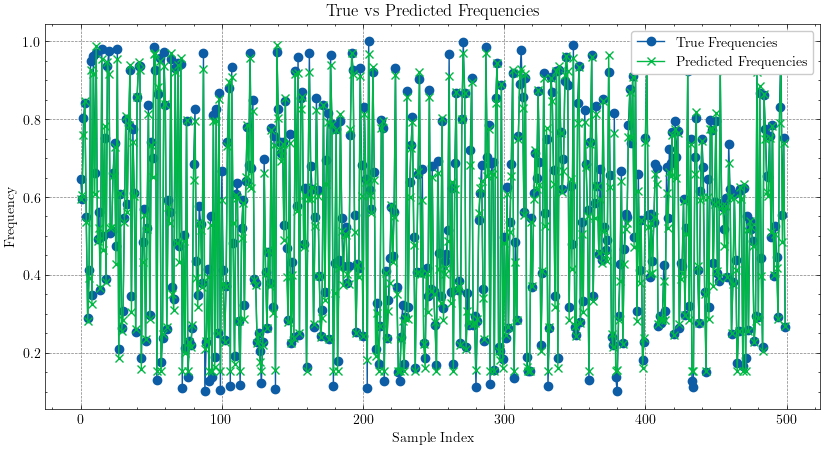

In [12]:
# plot the results
plt.figure(figsize=(10, 5))
plt.plot(y_test.numpy(), label="True Frequencies", marker='o')
plt.plot(y_pred_test.numpy(), label="Predicted Frequencies", marker='x')
plt.title("True vs Predicted Frequencies")
plt.xlabel("Sample Index")
plt.ylabel("Frequency")
plt.legend()
plt.show()

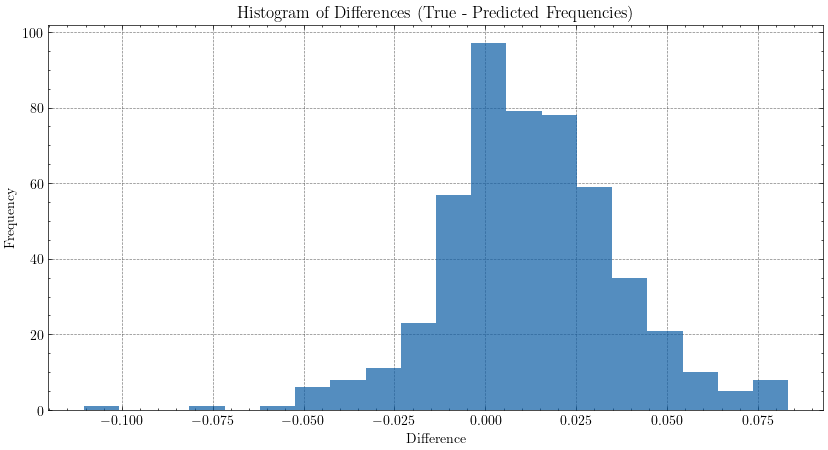

In [13]:
diffs = y_test - y_pred_test
# histogram of the differences
plt.figure(figsize=(10, 5))
plt.hist(diffs.numpy(), bins=20, alpha=0.7)
plt.title("Histogram of Differences (True - Predicted Frequencies)")
plt.xlabel("Difference")
plt.ylabel("Frequency")
plt.show() 

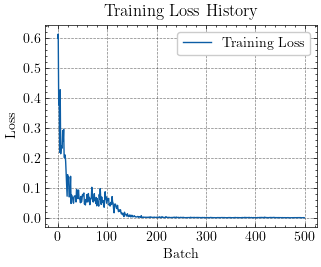

In [14]:
plt.plot(loss_hist, label="Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss History")
plt.legend()
plt.show()


In [15]:
params_hist_nice = {
    key: np.array([i[key].detach().numpy() for i in params_hist])
    for key in params_hist[0].keys()
}
print(params_hist_nice.keys())

dict_keys(['positions', 'local_pulses_omega_1', 'local_pulses_delta_1', 'global_pulse_omega_1', 'global_pulse_delta_1', 'global_pulse_omega_2', 'global_pulse_delta_2', 'global_pulse_duration', 'local_pulse_duration', 'embed_pulse_duration', 'conv_params', '0.weight', '0.bias', '2.weight', '2.bias', '4.weight', '4.bias'])


In [16]:
positions_hist = np.array([i["positions"].detach().numpy() for i in params_hist])
local_pulses_omega_1_hist = np.array([i["local_pulses_omega_1"].detach().numpy() for i in params_hist])
local_pulses_delta_1_hist = np.array([i["local_pulses_delta_1"].detach().numpy() for i in params_hist])

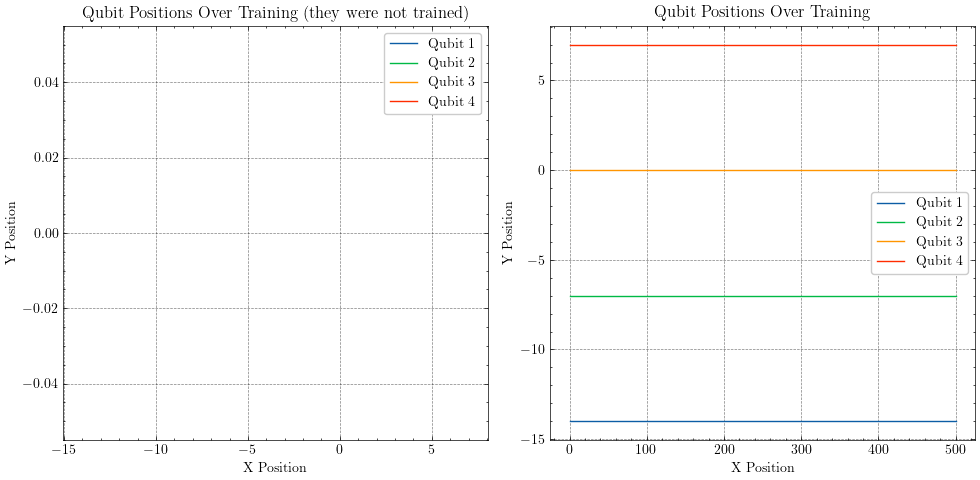

In [20]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plt.sca(axs[0])
for qubit in range(positions_hist.shape[1]):
    plt.plot(positions_hist[:, qubit, 0], positions_hist[:, qubit, 1], label=f"Qubit {qubit+1}")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training (they were not trained)")
plt.legend()
plt.sca(axs[1])
# only first qubit
plt.plot(positions_hist[:, 0, 0], label="Qubit 1")
plt.plot(positions_hist[:, 1, 0], label="Qubit 2")
plt.plot(positions_hist[:, 2, 0], label="Qubit 3")
plt.plot(positions_hist[:, 3, 0], label="Qubit 4")
# plt.plot(positions_hist[:, 4, 0], label="Qubit 5")
plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Qubit Positions Over Training")
plt.legend()
plt.tight_layout()  
plt.show()  

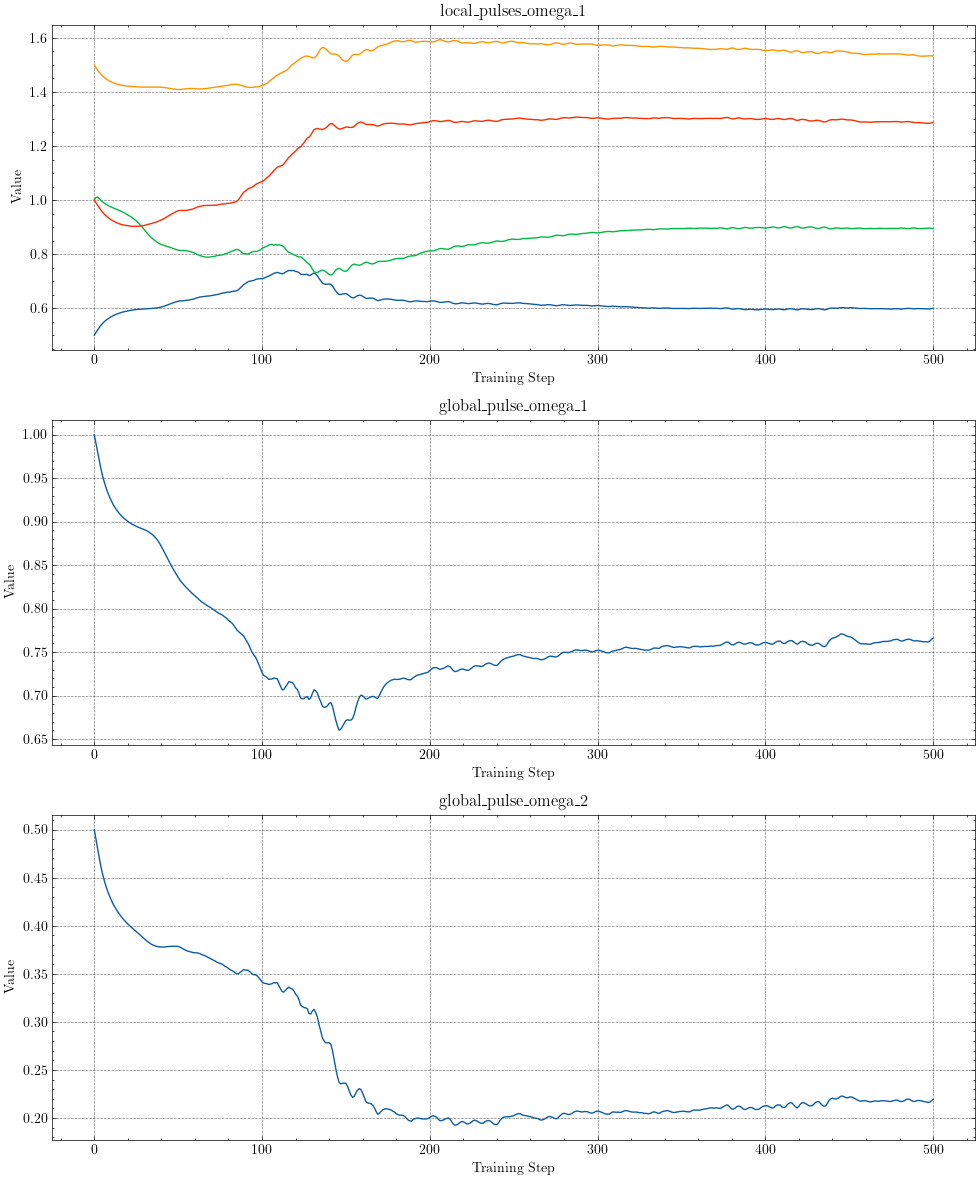

In [18]:
plot_keys = ['local_pulses_omega_1', 'global_pulse_omega_1', 'global_pulse_omega_2']
fig, axs = plt.subplots(len(plot_keys), 1, figsize=(10, 4 * len(plot_keys)))
for i, key in enumerate(plot_keys):
    axs[i].plot(params_hist_nice[key])
    axs[i].set_title(key)
    axs[i].set_xlabel("Training Step")
    axs[i].set_ylabel("Value")
plt.tight_layout()
plt.show()  

In [11]:
import pickle

# number of learned parameters, i.e. with require_grad=True
NAHEA_CNN.train()
# number of parameters
n_params = sum(v.numel() for p, v in NAHEA_CNN.parameters().items() if v.requires_grad)
print(f"Number of trainable parameters: {n_params}")
# save training history
os.makedirs("losses_hist", exist_ok=True)
with open("losses_hist/NAHEA_CNN_dist_grad_false_QNoTrain_train_hist_2025_07_28.pickle", "wb") as f:
    pickle.dump(
        {
            "loss_hist": loss_hist,
            "loss_hist_val": loss_hist_val,
            "params_hist": params_hist,
            "hparams": hparams,
            loss_test.item(): "test_loss",
            "n_learned_parameters": n_params,
        },
        f,
    )

Number of trainable parameters: 143


NameError: name 'loss_test' is not defined

In [15]:
# save final parameters
weights_dir = Path("weights")
weights_dir.mkdir(parents=True, exist_ok=True)
with open(weights_dir / "NAHEA_CNN_sin_dist_grad_false_QNoTrain_final_params_2025_07_28.pickle", "wb") as f:
    pickle.dump(NAHEA_CNN.parameters(), f)